## Outline

[Theory](#Theory)

[X data array creation](#X_data_array_creation)



<a name="Theory"></a>

# Theory

Little bit of theory from Florsch et al,. (2019)

### Éléments locaux du champ magnétique

<img src="Figures/Magnetic_field_local_elements.png" width=300 height=200 />

Terms:

H = Composante horizontale du champ vectoriel F(Induction magnétique B).

V = Composante Verticale du champ vectoriel F(Induction magnétique B).

D = Déclinaison.

I = Inclinaison.

### (a) La réalité d’un aimant. (b) Construction du champ pour un dipôle

<img src="Figures/Dipole_magnetique.png" width=400 height=200 />

Terms:

F = champ vectoriel (Induction magnétique B).

r = distance au point d'observation.

O = angle entre le point d'observation et l'axe du dipôle.



<a name="X_data_array_creation"></a>

# X data array creation

<a name='1'></a>
## 1.  Import Packages

We'll first import all the packages that we need. 



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle 
%matplotlib inline

import os
from sklearn.utils import shuffle 
import random
from skimage import draw
import pandas as pd
from scipy import ndimage
import cv2 

from PIL import Image

import seaborn as sns
sns.set()

from sklearn.utils import shuffle 

#%matplotlib notebook
np.set_printoptions(suppress=True)

<a name='1.1'></a>
### 1.1  Useful functions

In [2]:
os.chdir("../Utils_J")

from Utils_Magnetic_methods import * # all the functions created that will be useful 

os.chdir("../")

<a name='2.1'></a>
### 2.1  Model grid



In [3]:
grid_caracteristic = {
    
    'zmax': 100, # Total number of grid lines
    'map_lenght': 25 # [m] Our grid will be between (-map_lenght,map_lenght) because our anomalie is centered in (0,0)
}

zmax = grid_caracteristic['zmax']
map_lenght = grid_caracteristic['map_lenght']

X, Y = grid(zmax, map_lenght) # X and Y in [meters]

print(f'X array shape: {X.shape}')
print(f'Y array shape: {Y.shape}')
print(f'Cell lenght: {(map_lenght*2)/zmax}')

X array shape: (100, 1)
Y array shape: (1, 100)
Cell lenght: 0.5


<a name='2.2'></a>
### 2.2 Latitudes



In [4]:
lat_dict = {
    
    'lat_min': 0, #[°]
    'lat_max': 120, #[°]
    'lat_frequency': 30, #[°]
    
} 

lat_array, lat_array_rad, I = latitudes_array(lat_dict['lat_min'], lat_dict['lat_max'], lat_dict['lat_frequency'])

print(f'Latitudes: {lat_array} [°]') # °
print(f'Latitudes: {np.round(lat_array_rad, decimals=2)} [rad]') # °
print(f'Inclinaison: {np.round(I, decimals=2)} [rad]')



Latitudes: [ 0 30 60 90] [°]
Latitudes: [0.   0.52 1.05 1.57] [rad]
Inclinaison: [0.   0.86 1.29 1.57] [rad]


<a name='3'></a>
## 3.  Defining anomalies physical characteristics



In [5]:
r_v_d_dict = {
    
    'Br': 47000, #Champ local(nT)
    'ksi': 0.1, 
    'r_min': 0.1, #[meters]
    'r_max': 0.18, #[meters]
    'r_frequency':0.02, #[meters]
    'h_min': 1, #[meters]
    'h_max': 1.8, #[meters]
    'h_frequency': 0.2, #[meters]
    'h_capteur': 0.5#hauteur du capteur [meters]
    
}

Br = r_v_d_dict['Br']
ksi = r_v_d_dict['ksi']
r_min = r_v_d_dict['r_min']
r_max = r_v_d_dict['r_max']
r_frequency = r_v_d_dict['r_frequency']
h_min = r_v_d_dict['h_min']
h_max = r_v_d_dict['h_max']
h_frequency = r_v_d_dict['h_frequency'] 
h_capteur = r_v_d_dict['h_capteur'] 



r_array, V_array, h_array, h_capteur, n_examples, Parameters_array, m = r_V_h_array(r_min, r_max, r_frequency,
                                                                                    h_min, h_max, h_frequency, 
                                                                                    h_capteur, zmax, Br, ksi)

print(f'Radius: {np.round(r_array[:], decimals=3)} [meters]') # Last 3 examples

print(f'Volume: {V_array[:]} [m^3]') # Last 3 examples

print(f'Number of V: {V_array.shape[0]}') # Last 3 examples

print("---------------------------------------------")

print(f'Depth: {np.round(h_array[:], decimals = 2)} [meters]') # Last 3 examples

print(f'Number of h: {h_array.shape[0]}') # Last 3 examples

print("---------------------------------------------")

print(f'Sensor height: {h_capteur} [meters]') 

print("---------------------------------------------")

print(f'Number of examples: {n_examples}')
print(f'Parameters array shape: {Parameters_array.shape} 1st channel Volume, 2nd channel Depth') # 2 channels (1- Volume, 2- Depth)
print(f'Dipole magnetic moment: {m[-3:]} [A.m^2]')




Radius: [0.1  0.12 0.14 0.16] [meters]
Volume: [0.004 0.007 0.011 0.017] [m^3]
Number of V: 4
---------------------------------------------
Depth: [1.  1.2 1.4 1.6] [meters]
Number of h: 4
---------------------------------------------
Sensor height: 0.5 [meters]
---------------------------------------------
Number of examples: 16
Parameters array shape: (16, 2) 1st channel Volume, 2nd channel Depth
Dipole magnetic moment: [32.9 51.7 79.9] [A.m^2]


<a name='4'></a>
## 4.  Creating X and Y array 



<a name='4.1'></a>
### 4.1 Raw data (before data augmetation)



In [6]:
def X_array_raw(Br, m, I, X, Y, h, N_lat, examples, zmax, n_parameters, lat_array_rad, Parameters_array):

    X_array_raw = np.zeros((N_lat, examples, zmax, zmax)) # Array with magnetic induction values

    Parameters_array_raw = np.zeros((N_lat, examples, n_parameters)) # Array with volume and depth values

    i = 0

    for i_lat_rad in lat_array_rad:

        Anomalie = None

        r = np.sqrt(np.add(np.add(X**2, Y**2), (h**2).reshape(h.shape[0], 1, 1)))

        costeta = np.divide(((X * np.cos(I[i])) - (np.multiply(h.reshape(h.shape[0], 1, 1), np.sin(I[i])))), r)

        Anomalie = np.outer(m.reshape(m.shape[0],1,1), np.divide(3*(costeta**2) - 1, r**3)).reshape((examples,zmax,zmax))

        X_array_raw[i, :, :, :] = Anomalie

        Parameters_array_raw[i,:,:] = Parameters_array[:,:]

        i += 1
        
    return X_array_raw, Parameters_array_raw



In [7]:
### X_data array, Calculating Induction magnétique de l'Anomalie [nT] ###

X_Y_array_dict = {
    
    'N_latitudes': lat_array.shape[0], # Number of latitudes
    'N_parameters': Parameters_array.shape[1] # Number of parameters
}

N_latitudes = X_Y_array_dict["N_latitudes"]
N_parameters = X_Y_array_dict["N_parameters"]

X_data_array_raw, Parameters_array_raw = X_array_raw(Br, m, I, X, Y, h_array, N_latitudes, 
                                                     n_examples, zmax, N_parameters, 
                                                     lat_array_rad, Parameters_array)


print(f'X array raw shape: {X_data_array_raw.shape}')
print(f'Parameters array raw shape: {Parameters_array_raw.shape}')



X array raw shape: (4, 16, 100, 100)
Parameters array raw shape: (4, 16, 2)


In [8]:
par_window = 18

diff_max = int((zmax + par_window) / 2)
diff_min = int((zmax - par_window) / 2)

X_data_array_raw_2 = X_data_array_raw[:,:,diff_min:diff_max, diff_min:diff_max]

print(X_data_array_raw_2.shape)

(4, 16, 18, 18)


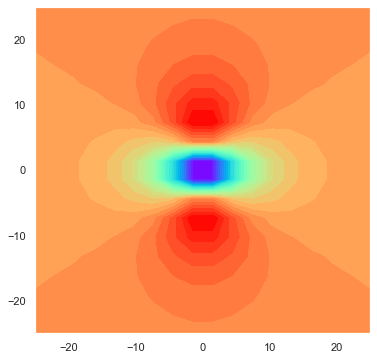

In [9]:
img = X_data_array_raw_2[0,0,:,:]

X_i = np.linspace(-map_lenght, map_lenght, par_window)
Y_i = np.linspace(-map_lenght, map_lenght, par_window)

plt.figure(figsize=(6,6))

plt.contourf(X_i, Y_i, img, levels = 40, cmap='rainbow')

<a name='4.2'></a>
### 4.2 Raw data visualization



Plotting model: 0


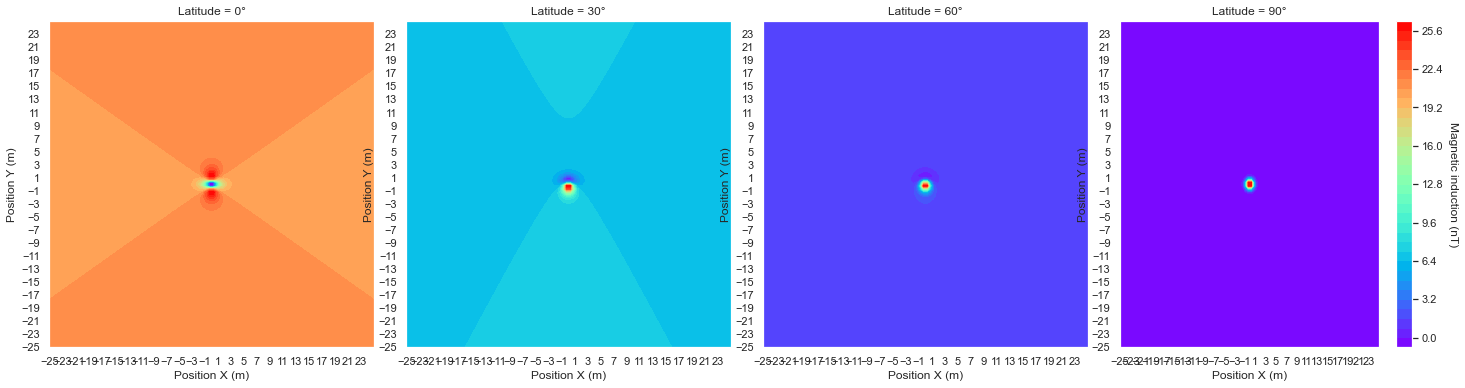

In [10]:
Raw_visualization_dict = {
    
    'height': 25,
    'width': 6,
    'example_to_plot': 'random', # Could be int or 'random'
    'n_model_aug': None, # Not yet
    'n_dipoles': None, # Not yet
    
}

height = Raw_visualization_dict['height']
width = Raw_visualization_dict['width']
n_model_aug = Raw_visualization_dict['n_model_aug']
n_dipoles = Raw_visualization_dict['n_dipoles']

rows = 1
cols = 4

example_to_plot = 0

par_window = 100

Plot_X_array_raw(map_lenght, height, width, example_to_plot, lat_array, X_data_array_raw, 
                 Parameters_array_raw, n_model_aug, n_dipoles, rows, cols, par_window)



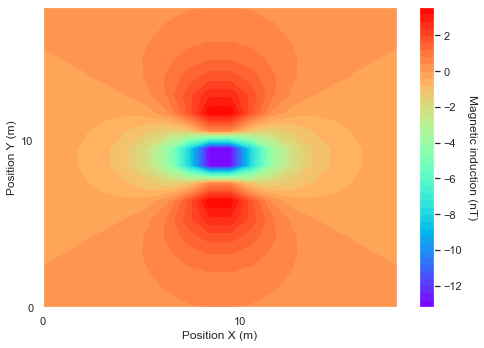

In [11]:
an_width = 18

No_pad_left = (X_data_array_raw.shape[2]//2) - an_width//2
No_pad_right = (X_data_array_raw.shape[2]//2) + an_width//2

img = X_data_array_raw[0,0,No_pad_left:No_pad_right,No_pad_left:No_pad_right]

plt.figure(figsize=(7,5))
plt.xticks(np.arange(0, 100, step=10))
plt.yticks(np.arange(0, 100, step=10))

X = np.linspace(0, 18, img.shape[1])
Y = np.linspace(0, 18, img.shape[1])

#plt.imshow(img)
plt.contourf(X, Y, img, levels = 50, cmap='rainbow')
plt.xlabel('Position X (m)')
#plt.xticks(np.arange(0, 18, step=1))
plt.ylabel('Position Y (m)')
#plt.yticks(np.arange(0, 18, step=1))
clb = plt.colorbar()
clb.set_label('Magnetic induction (nT)', labelpad=15, y=0.5, rotation=270)

plt.tight_layout()



<a name='4.5'></a>
### 4.5 Creating X array (counting number of dipoles and data augmentation)



In [12]:
def X_array(N_dipoles_f, N_parameters_f, dist_min_i, X_data_pad, Parameters_array_raw, rotation, h_array):

    #### Number of dipoles ###

    N_dipoles = N_dipoles_f
    N_parameters = N_parameters_f
    N_h = h_array.shape[0]
    
    ##########################
    
    h_counting = np.arange(0, N_h, 1)

    h_idx = np.tile(h_counting, N_h)
    
    ##########################

    N_lat = X_data_pad.shape[0]
    n_examples = X_data_pad.shape[1]
    zmax = int(X_data_pad.shape[2])
    border_o = int(zmax/2)
    
    ##########################
    
    conversion = (2*map_lenght)/zmax
    
    ##########################
    
    dist_min = dist_min_i / conversion
    
    ##########################

    X_data = np.zeros((N_lat, N_dipoles, n_examples, zmax, zmax))
    Parameters = np.zeros((N_lat, N_dipoles, n_examples, N_parameters ))
    Position = np.zeros((N_lat, N_dipoles, n_examples , N_dipoles*2))

    No_pad_left = int((zmax) - zmax/2)
    No_pad_right = int((zmax) + zmax/2)

    Position_array_to_add = np.zeros((N_lat,N_dipoles,n_examples, 2))
    
    w_in = 1

    for i_lat in range(0, N_lat, 1):
        
        for n_dipoles_i in range(0, N_dipoles, 1):

            for i_n_examples in range(0, n_examples, 1):
                
                #corr_min = int((zmax/2)-((box_confidence + ((h_idx[i_n_examples])*3))//2))
                #corr_max = int((zmax/2)+((box_confidence + ((h_idx[i_n_examples])*3))//2))
                                
                limit = (zmax/2) - 2
                dist_min_f = int(5 + (h_idx[i_n_examples]*1.5))
                

                if n_dipoles_i == 0:
                    
                    ##########################        
                    
                    position_x = 0
                    position_y = 0
                    
                    Position_array_to_add[i_lat, n_dipoles_i, i_n_examples, 0] = position_x + zmax/2
                    Position_array_to_add[i_lat, n_dipoles_i, i_n_examples, 1] = position_y + zmax/2
                    
                    ##########################
                    
                    if i_lat == 3:
                        
                        rot_n = 0 
                        
                    else:
                    
                        rot_n = random.choice(rotation)
                    
                    img = X_data_pad[i_lat,i_n_examples,:,:]
                        
                    X_array_rot = ndimage.rotate(img, rot_n, axes=(0,1), reshape=False)
                    
                    X_data_padded = cv2.copyMakeBorder(X_array_rot, border_o, border_o, border_o, border_o, 0)
                    
                    X_data_x = np.roll(X_data_padded, position_x, axis=1)
                    X_data_y = np.roll(X_data_x, position_y, axis=0)
                    
                    X_array_os = X_data_y[No_pad_left:No_pad_right,No_pad_left:No_pad_right]
                                            
                    X_data[i_lat,n_dipoles_i,i_n_examples,:,:] = X_array_os

                    ##########################
                    
                    Parameters[i_lat,n_dipoles_i:,i_n_examples,n_dipoles_i] = rot_n
                    Parameters[i_lat,n_dipoles_i:,i_n_examples,1:3] = np.round(Parameters_array_raw[i_lat,i_n_examples,:], 3)

                    ##########################
                    
                    Position[i_lat,n_dipoles_i:,i_n_examples,(n_dipoles_i)*2:(n_dipoles_i+1)*2] = np.round(Position_array_to_add[i_lat,n_dipoles_i,i_n_examples,:], 0)
                
                else:
                    
                    while w_in == 1:
                        
                        in_a = 0

                        position_x_0 = random.randint(-limit, -dist_min_f)
                        position_x_1 = random.randint(dist_min_f, limit)

                        position_x = random.choice([position_x_0, position_x_1])

                        position_y_0 = random.randint(-limit, -dist_min_f)
                        position_y_1 = random.randint(dist_min_f, limit)

                        position_y = random.choice([position_y_0, position_y_1])

                        X_c = ((position_x) - (Position_array_to_add[i_lat,:,i_n_examples,0] - zmax/2))

                        Y_c = ((position_y) - (Position_array_to_add[i_lat,:,i_n_examples,1] - zmax/2))

                        distance = np.sqrt(X_c**2 + Y_c**2)
                    
                        if np.all(dist_min < distance):
                            
                            break

                        else:
                            
                            if in_a >150:
                                
                                print("Looping forever?")
                            
                            in_a += 1

                            continue
                                        
                    Position_array_to_add[i_lat, n_dipoles_i, i_n_examples, 0] = position_x + zmax/2
                    Position_array_to_add[i_lat, n_dipoles_i, i_n_examples, 1] = position_y + zmax/2
                                        
                    ##########################
                    
                    if i_lat == 3:
                        
                        rot_n = 0 
                        
                    else:
                    
                        rot_n = random.choice(rotation)
                    
                    img = X_data_pad[i_lat,i_n_examples,:,:]
                        
                    X_array_rot = ndimage.rotate(img, rot_n, axes=(0,1), reshape=False)
                    
                    X_data_padded = cv2.copyMakeBorder(X_array_rot, border_o, border_o, border_o, border_o, 0)
                    
                    X_data_x = np.roll(X_data_padded, position_x, axis=1)
                    X_data_y = np.roll(X_data_x, position_y, axis=0)
                    
                    X_array_os = X_data_y[No_pad_left:No_pad_right,No_pad_left:No_pad_right]

                    X_data[i_lat,n_dipoles_i,i_n_examples,:,:] = X_data[i_lat,n_dipoles_i-1,i_n_examples,:,:] + X_array_os
                    
                    

                    ##########################
                    
                    #Parameters[i_lat,n_dipoles_i:,i_n_examples,n_dipoles_i*N_parameters] = rot_n
                    #Parameters[i_lat,n_dipoles_i:,i_n_examples,(n_dipoles_i*N_parameters)+1:(n_dipoles_i*N_parameters)+3] = np.round(Parameters_array_raw[i_lat,i_n_examples,:], 3)

                    ##########################
                    
                    Position[i_lat,n_dipoles_i:,i_n_examples,(n_dipoles_i)*2:(n_dipoles_i+1)*2] = np.round(Position_array_to_add[i_lat,n_dipoles_i,i_n_examples,:], 0)
                                                        
        
    return X_data, Parameters, Position

In [13]:
#### Data augmentation ####

N_models = 15

### Number of dipoles and min distance between dipoles ###

N_parameters_f = 3 #Latitude, Depth, Radius
N_dipoles_f = 10

##########################

dist_min_i = 5 # meters

##########################

rotation = np.arange(0, 180, 30)

##########################

X_data_f = np.zeros((N_models, N_latitudes, N_dipoles_f, n_examples, zmax, zmax))
Parameters_f = np.zeros((N_models, N_latitudes, N_dipoles_f, n_examples, N_parameters_f))
Position_f = np.zeros((N_models, N_latitudes, N_dipoles_f, n_examples , 2*N_dipoles_f))


for i_n_models in range(N_models):

    X_data_f[i_n_models,:,:,:,:], Parameters_f[i_n_models,:,:,:,:], Position_f[i_n_models,:,:,:,:] = X_array(N_dipoles_f, N_parameters_f, dist_min_i, X_data_array_raw, Parameters_array_raw , rotation, h_array)
    
    print(f"Model: {i_n_models+1} ready")
    
    

Model: 1 ready
Model: 2 ready
Model: 3 ready
Model: 4 ready
Model: 5 ready
Model: 6 ready
Model: 7 ready
Model: 8 ready
Model: 9 ready
Model: 10 ready
Model: 11 ready
Model: 12 ready
Model: 13 ready
Model: 14 ready
Model: 15 ready


In [14]:
X_data_f = np.moveaxis(X_data_f, 1, 0)
Parameters_final = np.moveaxis(Parameters_f, 1, 0)
Position_f = np.moveaxis(Position_f, 1, 0)

print(f"X_data shape: {X_data_f.shape}")
print(f"Parameters shape: {Parameters_final.shape}")
print(f"Position shape: {Position_f.shape}")



X_data shape: (4, 15, 10, 16, 100, 100)
Parameters shape: (4, 15, 10, 16, 3)
Position shape: (4, 15, 10, 16, 20)


parameters: [60.    0.16  1.  ]
parameters: [60.    0.16  1.4 ]
parameters: [90.   0.1  1.4]
parameters: [90.    0.12  1.4 ]
parameters: [60.    0.16  1.  ]
parameters: [0.  0.1 1.2]
parameters: [150.     0.12   1.2 ]
parameters: [0.   0.14 1.4 ]
parameters: [30.    0.14  1.  ]
parameters: [60.    0.16  1.  ]


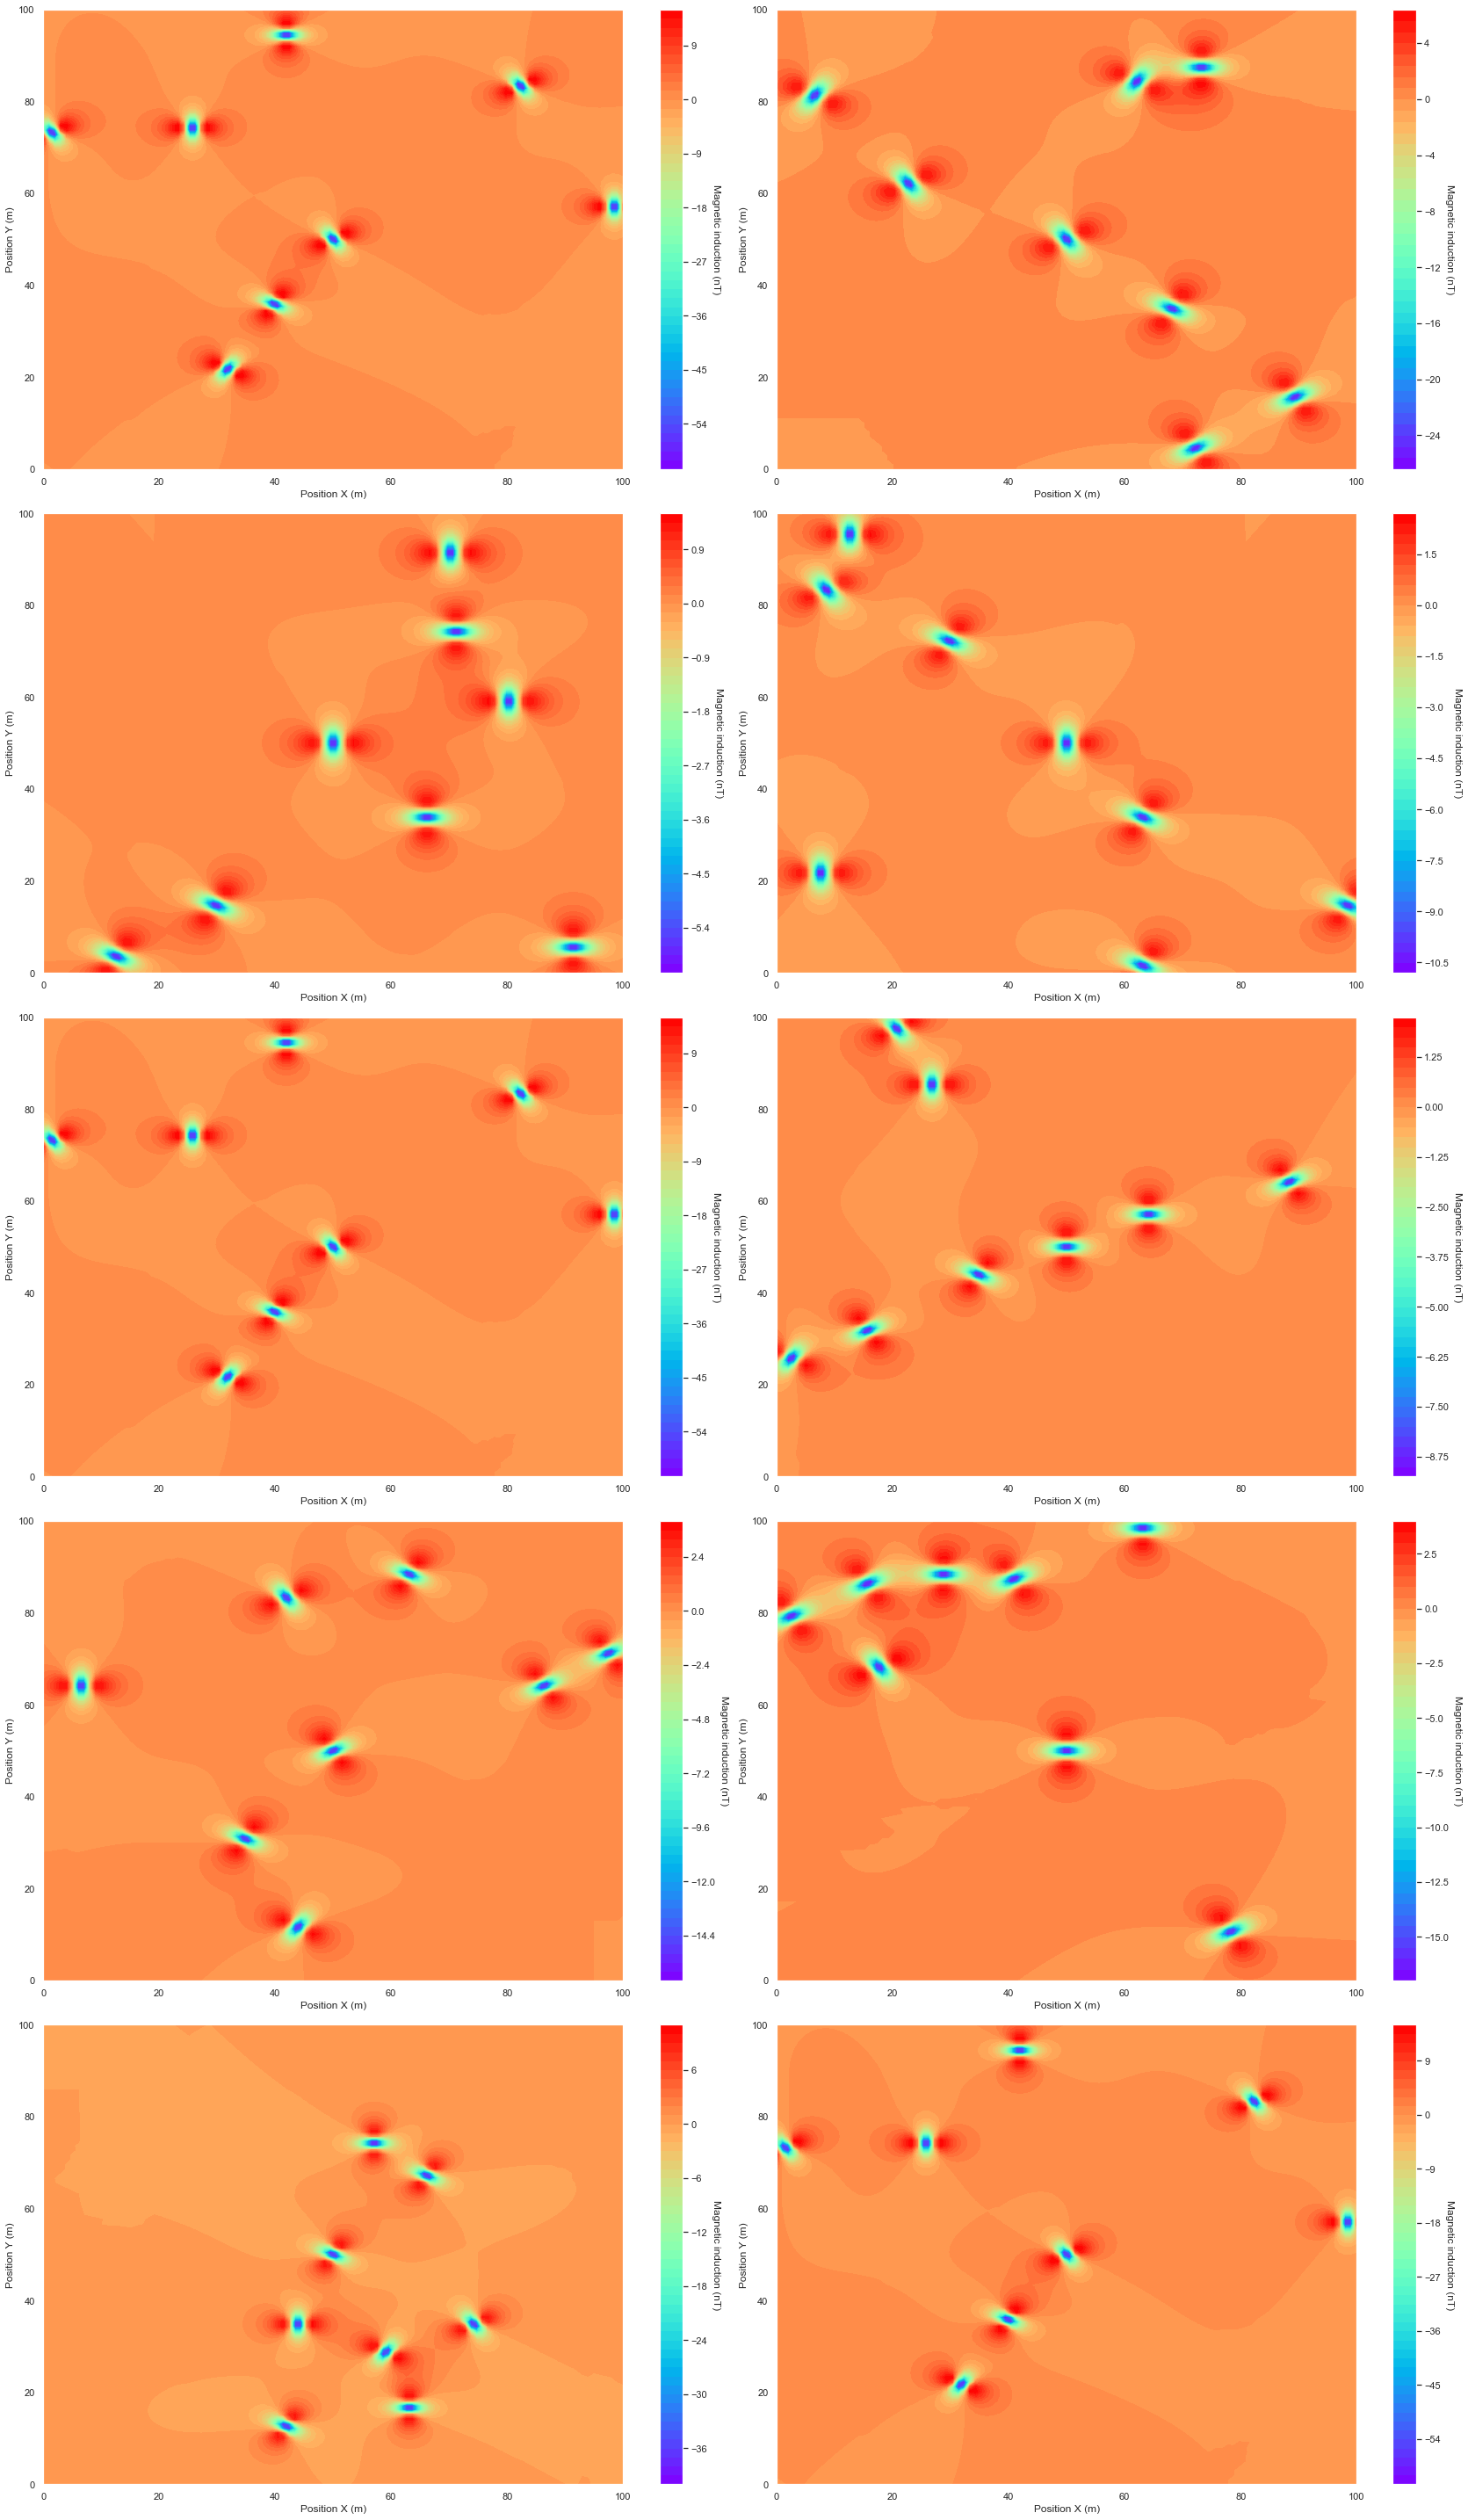

In [15]:
##############################

conversion = (map_lenght*2)/zmax

i_nn = 0

height = 24
width = 40

plt.figure(figsize=(height, width))

X = np.linspace(0, zmax, zmax)
Y = np.linspace(0, zmax, zmax)

for n_i in range(10):
    
    Lat_to_plot = 0

    model_to_plot = 0

    n_dipoles_to_plot = 7

    example_to_plot = np.random.randint(X_data_f.shape[3])
   # example_to_plot = 4
        
    plt.subplot(5, 2, n_i + 1)

    #plt.imshow(X_data_f[Lat_to_plot, model_to_plot, n_dipoles_to_plot, example_to_plot,:,:])
    plt.contourf(X, Y, X_data_f[Lat_to_plot, model_to_plot, n_dipoles_to_plot, example_to_plot,:,:], levels = 50, cmap='rainbow')
    plt.axis('on')
    plt.xlabel('Position X (m)')
    #plt.xticks(np.arange(0, 18, step=1))
    plt.ylabel('Position Y (m)')
    #plt.yticks(np.arange(0, 18, step=1))
    #plt.grid(color='r', linestyle='-', linewidth=10)
    #plt.title()
    clb = plt.colorbar()
    clb.set_label('Magnetic induction (nT)', labelpad=15, y=0.5, rotation=270)
        
    print(f'parameters: {Parameters_final[Lat_to_plot,model_to_plot,n_dipoles_to_plot,example_to_plot,:]}')
    #print(f'position: {np.round((Position_f[Lat_to_plot,model_to_plot,n_dipoles_to_plot,example_to_plot+n_i,:] - zmax/2) * conversion,0)}')
    
    i_nn += 1
    
    plt.tight_layout()
    
    
    

In [16]:
def Cropping_models(X_data_f, h_array, box_confidence, new_size):
    
    zmax = X_data_f.shape[4]
    
    N_h = h_array.shape[0]
    
    X_array_final = np.zeros((X_data_f.shape[0], X_data_f.shape[1], X_data_f.shape[2], X_data_f.shape[3], new_size, new_size))
    
    ##########################
    
    h_counting = np.arange(0, N_h, 1)

    h_idx = np.tile(h_counting, N_h)
    
    for i_lat in range(X_data_f.shape[0]):
        
        for d_a_models in range(X_data_f.shape[1]):
        
            for n_dipoles_i in range(X_data_f.shape[2]):

                for n_examples in range(X_data_f.shape[3]):

                    box_bottom = random.choice(box_confidence)
                    box_top =  random.choice(box_confidence)
                    box_left = random.choice(box_confidence)
                    box_right = random.choice(box_confidence)

                    bottom = int((zmax//2) - ((box_bottom + ((h_idx[n_examples])*3))//2))
                    top = int((zmax//2) + ((box_top + ((h_idx[n_examples])*3))//2))
                    left = int((zmax//2) - ((box_left + ((h_idx[n_examples])*3))//2))
                    right = int((zmax//2) + ((box_right + ((h_idx[n_examples])*3))//2))

                    X_array_os = X_data_f[i_lat, d_a_models, n_dipoles_i, n_examples, :, :]
                    
                    X_array_size = X_array_os[bottom:top,left:right]

                    while X_array_size.shape[0] !=  X_array_size.shape[1]:

                        if (X_array_size.shape[0]>X_array_size.shape[1]):
                            t_b_distance = top - bottom
                            t_b_center = top - ((top - bottom)/2)

                            if (t_b_center - left) < (right - t_b_center):
                                X_array_size = cv2.copyMakeBorder(X_array_size, 0, 0, (X_array_size.shape[0]-X_array_size.shape[1]), 0, cv2.BORDER_CONSTANT, value=0)

                            elif(t_b_center - left) == (right - t_b_center):
                                X_array_size = cv2.copyMakeBorder(X_array_size, 0, 0, (X_array_size.shape[0]-X_array_size.shape[1])//2, (X_array_size.shape[0]-X_array_size.shape[1])//2, cv2.BORDER_CONSTANT, value=0)

                            else:
                                X_array_size = cv2.copyMakeBorder(X_array_size, 0, 0, 0, (X_array_size.shape[0]-X_array_size.shape[1]), cv2.BORDER_CONSTANT, value=0)
                        else:
                            l_r_distance = right - left
                            l_r_center = right - ((right - left)/2)

                            if (l_r_center - bottom) < (top - l_r_center):
                                X_array_size = cv2.copyMakeBorder(X_array_size, 0, (X_array_size.shape[1]-X_array_size.shape[0]), 0, 0, cv2.BORDER_CONSTANT, value=0)

                            elif (l_r_center - bottom) == (top - l_r_center):
                                X_array_size = cv2.copyMakeBorder(X_array_size, (X_array_size.shape[1]-X_array_size.shape[0])//2, (X_array_size.shape[1]-X_array_size.shape[0])//2, 0, 0, cv2.BORDER_CONSTANT, value=0)

                            else:
                                X_array_size = cv2.copyMakeBorder(X_array_size, (X_array_size.shape[1]-X_array_size.shape[0]), 0, 0, 0, cv2.BORDER_CONSTANT, value=0)

                    border = (new_size-X_array_size.shape[1])//2

                    X_array_size_pad = cv2.copyMakeBorder(X_array_size, border, border, border, border, 0)

                    if X_array_size_pad.shape[0] !=  new_size:

                        X_array_f = cv2.copyMakeBorder(X_array_size_pad, 1, 0, 1, 0, 0)

                    else:

                        X_array_f = X_array_size_pad

                    X_array_final[i_lat, d_a_models, n_dipoles_i, n_examples, :, :] = X_array_f

    return X_array_final

In [17]:
##################

box_confidence = np.arange(8, 27, 1)

##################

new_size = 96

##################

X_array_final = Cropping_models(X_data_f, h_array, box_confidence, new_size)

parameters: [0.  0.1 1. ]
parameters: [0.   0.16 1.2 ]
parameters: [0.  0.1 1.4]
parameters: [0.   0.16 1.6 ]
parameters: [0.   0.12 1.  ]
parameters: [0.  0.1 1.6]
parameters: [0.   0.12 1.4 ]
parameters: [0.   0.16 1.  ]
parameters: [0.   0.12 1.  ]
parameters: [0.   0.16 1.6 ]


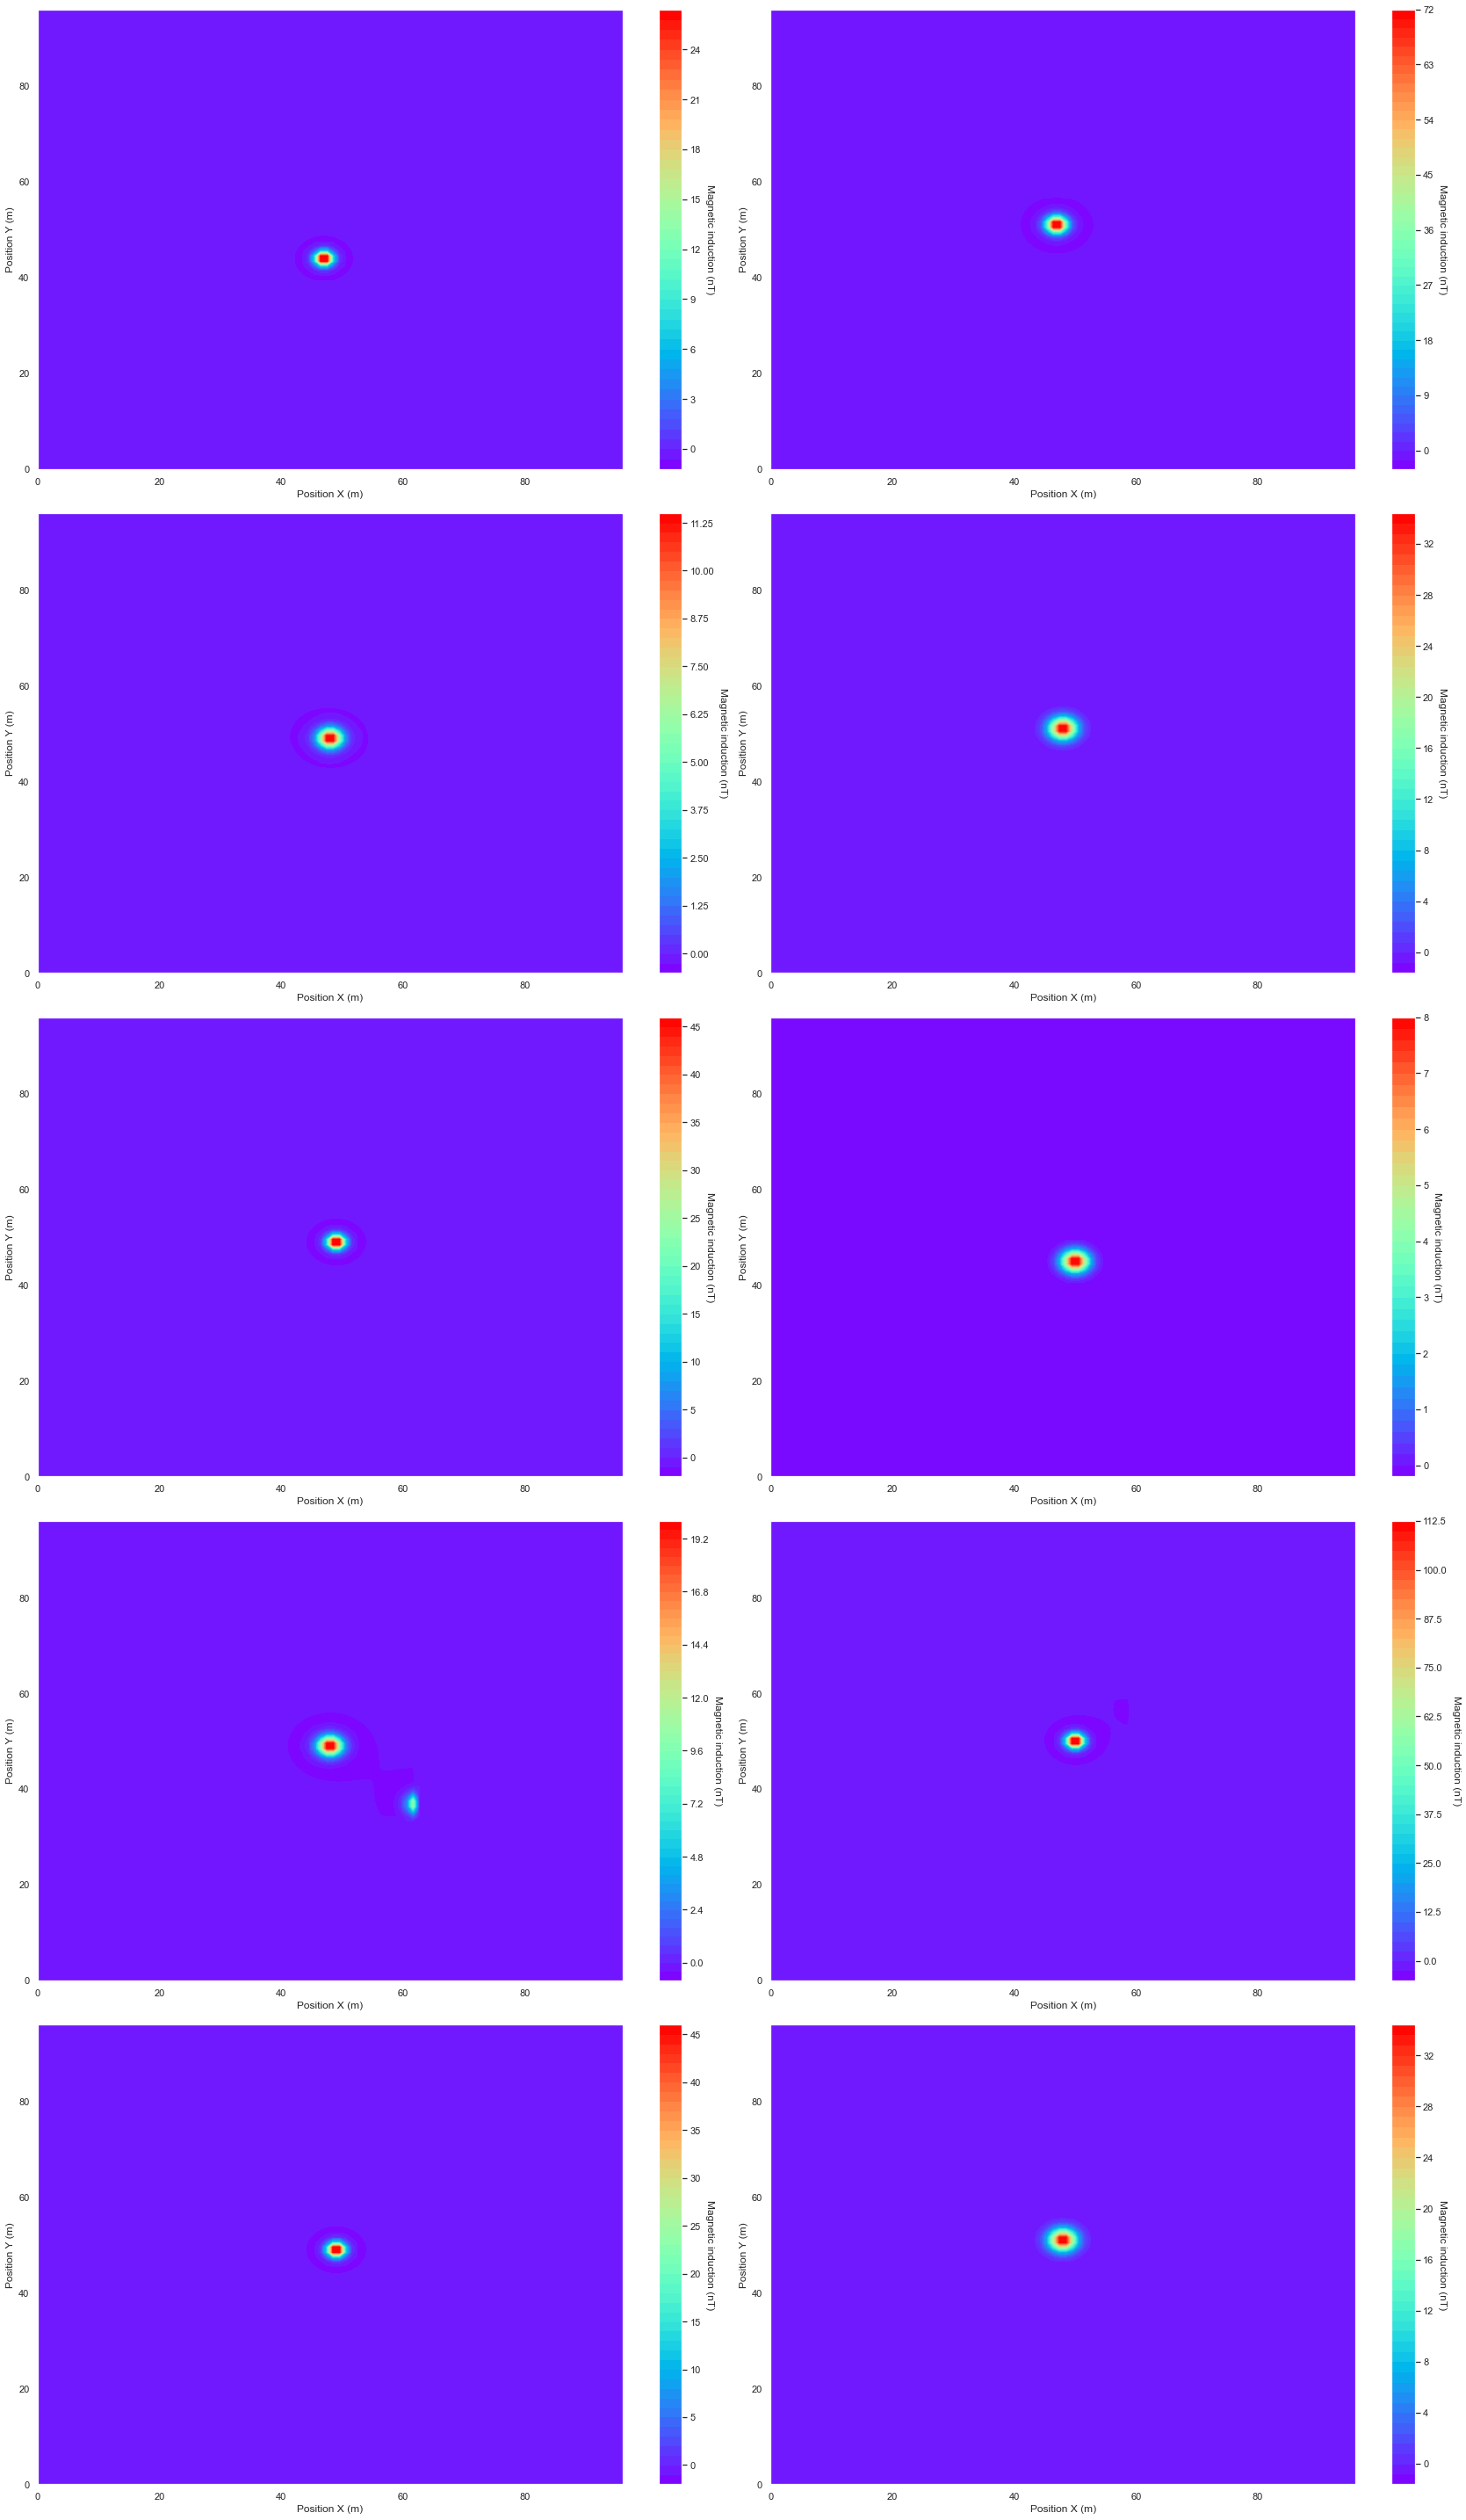

In [18]:
##############################

conversion = (map_lenght*2)/new_size

i_nn = 0

height = 24
width = 40

plt.figure(figsize=(height, width))

X = np.linspace(0, new_size, new_size)
Y = np.linspace(0, new_size, new_size)

for n_i in range(10):
    
    Lat_to_plot = 3

    model_to_plot = 0

    n_dipoles_to_plot = 7

    example_to_plot = np.random.randint(X_data_f.shape[3])
   # example_to_plot = 4
        
    plt.subplot(5, 2, n_i + 1)

    #plt.imshow(X_data_f[Lat_to_plot, model_to_plot, n_dipoles_to_plot, example_to_plot,:,:])
    plt.contourf(X, Y, X_array_final[Lat_to_plot, model_to_plot, n_dipoles_to_plot, example_to_plot,:,:], levels = 50, cmap='rainbow')
    plt.axis('on')
    plt.xlabel('Position X (m)')
    #plt.xticks(np.arange(0, 18, step=1))
    plt.ylabel('Position Y (m)')
    #plt.yticks(np.arange(0, 18, step=1))
    #plt.grid(color='r', linestyle='-', linewidth=10)
    #plt.title()
    clb = plt.colorbar()
    clb.set_label('Magnetic induction (nT)', labelpad=15, y=0.5, rotation=270)
        
    print(f'parameters: {Parameters_final[Lat_to_plot,model_to_plot,n_dipoles_to_plot,example_to_plot,:]}')
    #print(f'position: {np.round((Position_f[Lat_to_plot,model_to_plot,n_dipoles_to_plot,example_to_plot+n_i,:] - zmax/2) * conversion,0)}')
    
    i_nn += 1
    
    plt.tight_layout()
    
    
    

### rearranging database shape

In [19]:
def rearrange_dipoles(X_data_array, Parameters_f, Y_pos):
    
    X_data_array_final = X_data_array.reshape(X_data_array.shape[0], X_data_array.shape[1]*X_data_array.shape[2]*X_data_array.shape[3]
                                              ,X_data_array.shape[4], X_data_array.shape[5])

    Parameters_final = Parameters_f.reshape(Parameters_f.shape[0], Parameters_f.shape[1]*Parameters_f.shape[2]*Parameters_f.shape[3],
                                            Parameters_f.shape[4])
    
    Y_pos_final = Y_pos.reshape(Y_pos.shape[0], Y_pos.shape[1]*Y_pos.shape[2]*Y_pos.shape[3],
                                Y_pos.shape[4])
        
    return X_data_array_final, Parameters_final, Y_pos_final




In [20]:
X_array_final, Parameters_f, Y_position = rearrange_dipoles(X_array_final, Parameters_final, Position_f[:,:,:,:,:2])

In [21]:
print(f'X_data shape:{X_array_final.shape}') 
print(f'Y_par shape: {Parameters_f.shape}')
print(f'Y_position shape: {Y_position.shape}')



X_data shape:(4, 2400, 96, 96)
Y_par shape: (4, 2400, 3)
Y_position shape: (4, 2400, 2)


In [22]:
random_seed_2 = 14

for lat_i in range(X_data_f.shape[0]):

    X_array_final[lat_i,:] = shuffle(X_array_final[lat_i,:], random_state=random_seed_2)
    Parameters_f[lat_i,:] = shuffle(Parameters_f[lat_i,:], random_state=random_seed_2)
    Y_position[lat_i,:] = shuffle(Y_position[lat_i,:], random_state=random_seed_2)
    

In [23]:
train_rate = 0.70
dev_rate = 0.25
test_rate = 0.05

examples_t = X_array_final.shape[1]

X_train = np.concatenate((X_array_final[0,:int(examples_t*train_rate),:,:],X_array_final[1,:int(examples_t*train_rate),:,:],X_array_final[2,:int(examples_t*train_rate),:,:],X_array_final[3,:int(examples_t*train_rate),:,:]), axis=0)
Y_par_train = np.concatenate((Parameters_f[0,:int(examples_t*train_rate),:],Parameters_f[1,:int(examples_t*train_rate),:],Parameters_f[2,:int(examples_t*train_rate),:],Parameters_f[3,:int(examples_t*train_rate),:]), axis=0)
Y_pos_train = np.concatenate((Y_position[0,:int(examples_t*train_rate),:],Y_position[1,:int(examples_t*train_rate),:],Y_position[2,:int(examples_t*train_rate),:],Y_position[3,:int(examples_t*train_rate),:]), axis=0)

X_dev = np.concatenate((X_array_final[0,int(examples_t*train_rate):int(examples_t*(train_rate+dev_rate)),:,:],X_array_final[1,int(examples_t*train_rate):int(examples_t*(train_rate+dev_rate)),:,:],X_array_final[2,int(examples_t*train_rate):int(examples_t*(train_rate+dev_rate)),:,:],X_array_final[3,int(examples_t*train_rate):int(examples_t*(train_rate+dev_rate)),:,:]), axis=0)
Y_par_dev = np.concatenate((Parameters_f[0,int(examples_t*train_rate):int(examples_t*(train_rate+dev_rate)),:],Parameters_f[1,int(examples_t*train_rate):int(examples_t*(train_rate+dev_rate)),:],Parameters_f[2,int(examples_t*train_rate):int(examples_t*(train_rate+dev_rate)),:],Parameters_f[3,int(examples_t*train_rate):int(examples_t*(train_rate+dev_rate)),:]), axis=0)
Y_pos_dev = np.concatenate((Y_position[0,int(examples_t*train_rate):int(examples_t*(train_rate+dev_rate)),:],Y_position[1,int(examples_t*train_rate):int(examples_t*(train_rate+dev_rate)),:],Y_position[2,int(examples_t*train_rate):int(examples_t*(train_rate+dev_rate)),:],Y_position[3,int(examples_t*train_rate):int(examples_t*(train_rate+dev_rate)),:]), axis=0)

X_test = np.concatenate((X_array_final[0,int(examples_t*(train_rate+dev_rate)):,:,:],X_array_final[1,int(examples_t*(train_rate+dev_rate)):,:,:],X_array_final[2,int(examples_t*(train_rate+dev_rate)):,:,:],X_array_final[3,int(examples_t*(train_rate+dev_rate)):,:,:]), axis=0)
Y_par_test = np.concatenate((Parameters_f[0,int(examples_t*(train_rate+dev_rate)):,:],Parameters_f[1,int(examples_t*(train_rate+dev_rate)):,:],Parameters_f[2,int(examples_t*(train_rate+dev_rate)):,:],Parameters_f[3,int(examples_t*(train_rate+dev_rate)):,:]), axis=0)
Y_pos_test = np.concatenate((Y_position[0,int(examples_t*(train_rate+dev_rate)):,:],Y_position[1,int(examples_t*(train_rate+dev_rate)):,:],Y_position[2,int(examples_t*(train_rate+dev_rate)):,:],Y_position[3,int(examples_t*(train_rate+dev_rate)):,:]), axis=0)




In [24]:
def rearrange_final(X_data_array, Parameters_f, Y_pos, N_dipoles_f):
    
    X_data_array_final = X_data_array.reshape(X_data_array.shape[0],X_data_array.shape[1],X_data_array.shape[2],1)

    Y_par_final = Parameters_f.reshape(Parameters_f.shape[0],3)
    
    Y_pos_final = Y_pos.reshape(Y_pos.shape[0],2)
    
    return X_data_array_final, Y_par_final, Y_pos_final

In [25]:
X_train, Y_par_train, Y_pos_train = rearrange_final(X_train, Y_par_train, Y_pos_train, N_dipoles_f)

X_dev, Y_par_dev, Y_pos_dev  = rearrange_final(X_dev, Y_par_dev, Y_pos_dev, N_dipoles_f)

X_test, Y_par_test, Y_pos_test = rearrange_final(X_test, Y_par_test, Y_pos_test, N_dipoles_f)





In [26]:
print(X_train.shape, Y_par_train.shape, Y_pos_train.shape)
print(X_dev.shape, Y_par_dev.shape, Y_pos_dev.shape)
print(X_test.shape, Y_par_test.shape, Y_pos_test.shape)

(6720, 96, 96, 1) (6720, 3) (6720, 2)
(2400, 96, 96, 1) (2400, 3) (2400, 2)
(480, 96, 96, 1) (480, 3) (480, 2)


In [27]:
    

def shuffle_final(X, par, pos, random_seed_3):
    
    X = shuffle(X[:], random_state=random_seed_3)
    par = shuffle(par[:], random_state=random_seed_3)
    pos = shuffle(pos[:], random_state=random_seed_3)
    
    return X, par, pos

In [28]:
random_seed_3 = 25

X_train, Y_par_train, Y_pos_train = shuffle_final(X_train, Y_par_train, Y_pos_train, random_seed_3)
X_dev, Y_par_dev, Y_pos_dev = shuffle_final(X_dev, Y_par_dev, Y_pos_dev, random_seed_3)
X_test, Y_par_test, Y_pos_test = shuffle_final(X_test, Y_par_test, Y_pos_test, random_seed_3)




In [29]:
print("Total examples: {:.0f}".format(X_train.shape[0]+X_dev.shape[0]+X_test.shape[0]))

Total examples: 9600


<a name='4.7'></a>
### 4.7 X,Y data visualization



------------------------------
parameters: [0.   0.12 1.4 ]
------------------------------
parameters: [120.     0.14   1.6 ]
------------------------------
parameters: [120.     0.16   1.2 ]
------------------------------
parameters: [0.  0.1 1.4]
------------------------------
parameters: [30.    0.16  1.6 ]
------------------------------
parameters: [30.    0.16  1.6 ]
------------------------------
parameters: [60.    0.16  1.6 ]
------------------------------
parameters: [0.   0.16 1.2 ]
------------------------------
parameters: [60.    0.14  1.4 ]


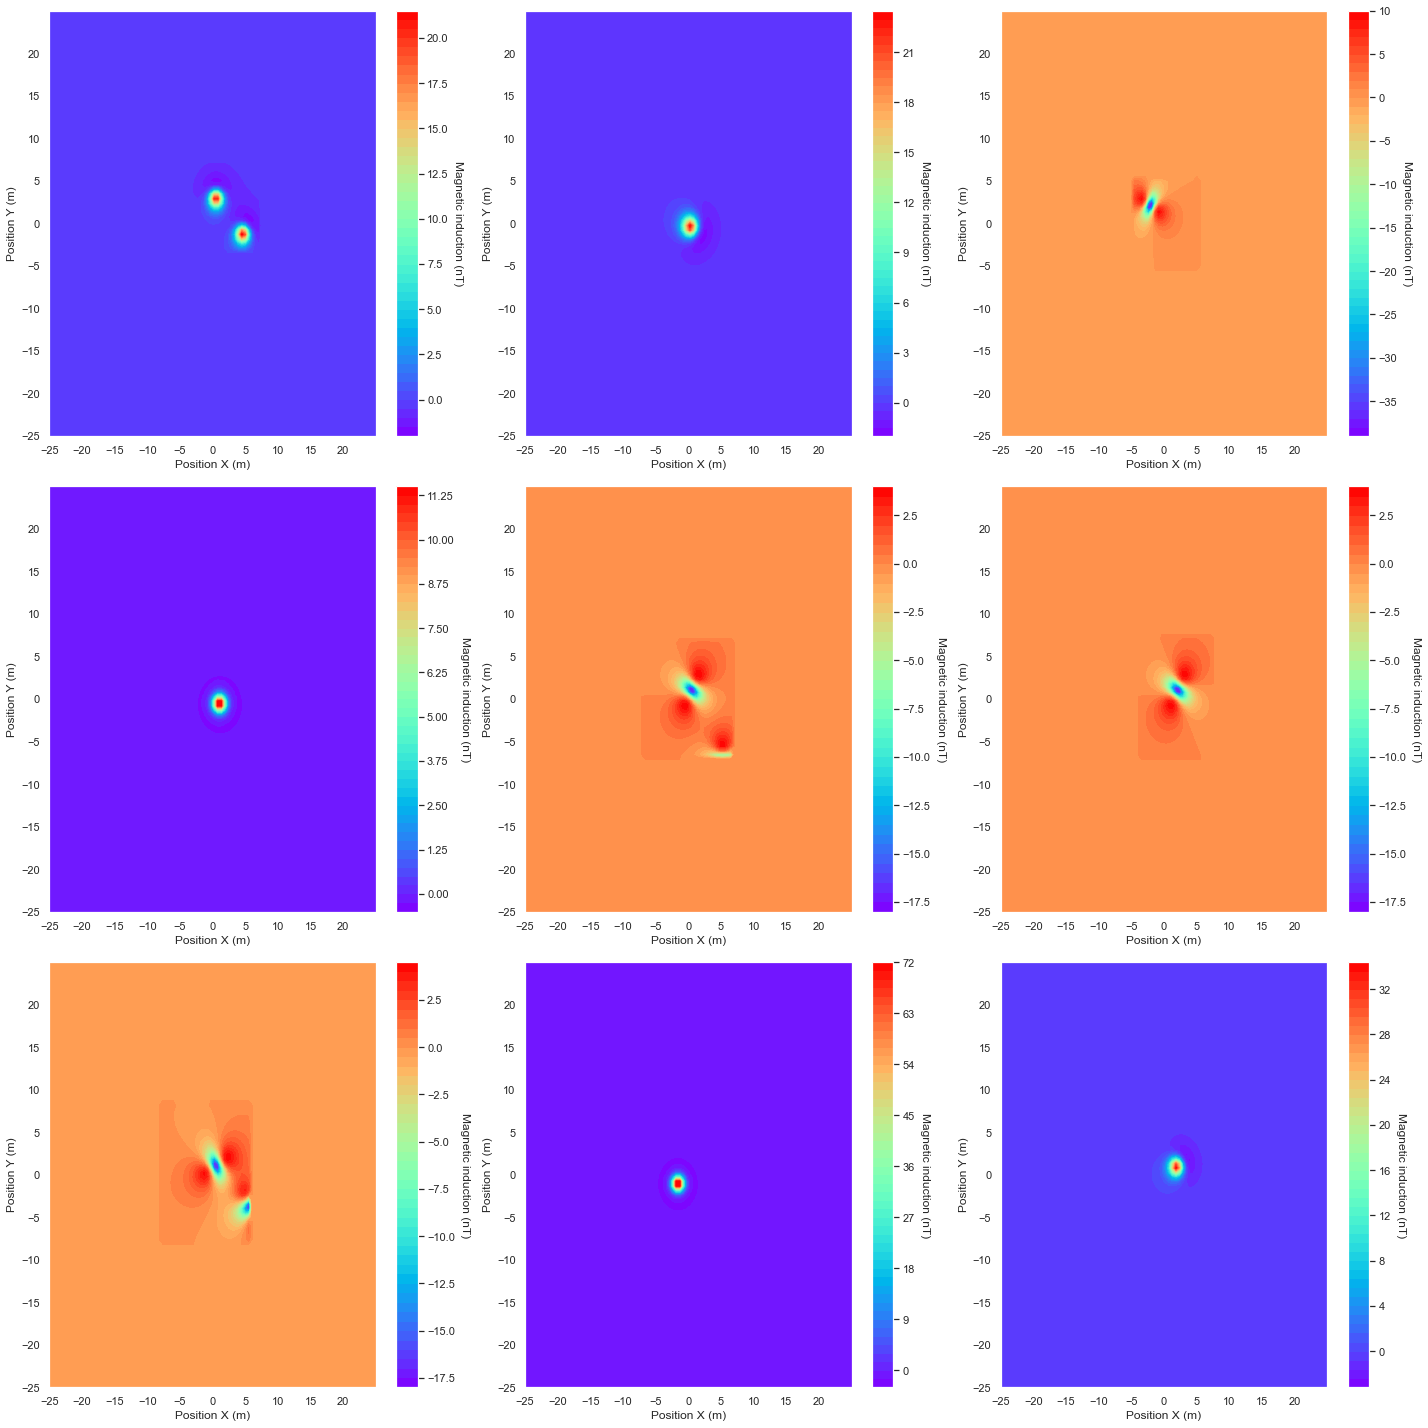

In [30]:
height_2 = 20
width_2 = 20

##############################

plt.figure(figsize=(width_2, height_2))

X = np.linspace(-map_lenght, map_lenght, 96)
Y = np.linspace(-map_lenght, map_lenght, 96)

for n_i in range(9):
    
    model_to_plot_l = int(np.random.randint(0, X_train.shape[0], 1))
    
    plt.subplot(3, 3, n_i + 1)
    plt.contourf(X, Y, X_train[model_to_plot_l,:,:,0], levels = 50, cmap='rainbow')
    plt.xlabel('Position X (m)')
    plt.xticks(np.arange(-25, 25, step=5))
    plt.ylabel('Position Y (m)')
    plt.yticks(np.arange(-25, 25, step=5))
    clb = plt.colorbar()
    clb.set_label('Magnetic induction (nT)', labelpad=15, y=0.5, rotation=270)
    
    print('---'*10)
    
    print(f'parameters: {Y_par_train[model_to_plot_l,:]}')
    
    i_nn += 1
    
    plt.tight_layout()



<a name='4.8'></a>
### 4.8 Adding Gaussian noise



def gaussian_noise_models(mean, var, sigma, n_models_with_noise, zmax, X_data_array, Y_par, Y_seg): 
    
    mean = 0
    
    X_data_array_with_noise = np.zeros((n_models_with_noise,zmax,zmax,X_data_array.shape[3]))
    Y_par_with_noise = np.zeros((n_models_with_noise,Y_par.shape[1],Y_par.shape[2]))
    Y_seg_with_noise = np.zeros((n_models_with_noise,Y_seg.shape[1],Y_seg.shape[2], Y_seg.shape[3]))
    
    n_i = random.sample(range(X_data_array.shape[0]-1), n_models_with_noise)
    

    for i_noise_models in range(0, n_models_with_noise, 1):
        
        m = n_i[i_noise_models]
        
        if np.max(X_data_array[m,:,:,0]) < 10:
            
            var = 0.03
            
        elif np.max(X_data_array[m,:,:,0]) < 100:
            
            var = 0.3
            
        elif np.max(X_data_array[m,:,:,0]) < 1000:
            
            var = 3
        
        sigma = var ** 0.5
        
        gaussian = np.random.normal(mean, sigma, (zmax,zmax)) 

        X_data_array_with_noise[i_noise_models,:,:,0] = X_data_array[m,:,:,0] + gaussian
        
        Y_par_with_noise[i_noise_models,:,:] = Y_par[m,:,:]
        
        Y_seg_with_noise[i_noise_models,:,:,:] = Y_seg[m,:,:,:]
        
        
    return X_data_array_with_noise, Y_par_with_noise, Y_seg_with_noise, n_i

# Gaussian_noise_dict = {
    
    "mean": 0,
    "var": 0.1,
    "n_models_with_noise": 1000 # Number of models with noise
    
}

sigma = Gaussian_noise_dict['var'] ** 0.5

X_data_array_with_noise, Y_par_with_noise, Y_seg_with_noise, n_i = gaussian_noise_models(Gaussian_noise_dict['mean'], Gaussian_noise_dict['var'], 
                                                                                         sigma, Gaussian_noise_dict['n_models_with_noise'], 
                                                                                         zmax, X_train, Y_train, Y_train_seg)
    

<a name='4.9'></a>
### 4.9 Gaussian noise models visualization

# mode = 'X'

#Gn_model = int(np.random.randint(len(n_i)-3))

Gn_model = 2

mtp = n_i[Gn_model-1]

print(mtp)

final_plot(mode, X_train, Y_train, mtp)



# mode = 'X'

Gn_model = int(np.random.randint(Y_par_with_noise.shape[0]))

final_plot(mode, X_data_array_with_noise, Y_par_with_noise, Gn_model)

X_train = np.concatenate((X_train, X_data_array_with_noise), axis=0)
Y_train = np.concatenate((Y_train, Y_par_with_noise), axis=0)
Y_train_seg = np.concatenate((Y_train_seg, Y_seg_with_noise), axis=0)

print(X_train.shape)
print(Y_train.shape)
print(Y_train_seg.shape)

random_seed_2 = 125

X_train = shuffle(X_train, random_state=random_seed_2)

Y_train = shuffle(Y_train, random_state=random_seed_2)

Y_train_seg = shuffle(Y_train_seg, random_state=random_seed_2)

In [31]:
N_total_examples = X_train.shape[0] + X_dev.shape[0] + X_test.shape[0]

print(f'Total number of examples : {N_total_examples}')
print(f'Train : {X_train.shape[0]}')
print(f'Dev : {X_dev.shape[0]}')
print(f'Test : {X_test.shape[0]}')

Total number of examples : 9600
Train : 6720
Dev : 2400
Test : 480


<a name='4.10'></a>
### 4.10 h5py file creation



In [33]:
import h5py

def create_hdf5_train_dev_test(path, file_name, X_train, X_dev, X_test, Y_par_train, Y_par_dev, Y_par_test):
 
    
    hdf5_path = path + file_name
    
    hdf5_file = h5py.File(hdf5_path, mode='w')
    hdf5_file.create_dataset("X_train", X_train.shape)
    hdf5_file["X_train"][:,:,:,:] = X_train[:,:,:,:]
    hdf5_file.create_dataset("X_dev", X_dev.shape)
    hdf5_file["X_dev"][:,:,:,:] = X_dev[:,:,:,:]
    hdf5_file.create_dataset("X_test", X_test.shape)
    hdf5_file["X_test"][:,:,:,:] = X_test[:,:,:,:]
    
    hdf5_file.create_dataset("Y_train", Y_par_train.shape)
    hdf5_file["Y_train"][:,:] = Y_par_train[:,:]
    hdf5_file.create_dataset("Y_dev", Y_par_dev.shape)
    hdf5_file["Y_dev"][:,:] = Y_par_dev[:,:]
    hdf5_file.create_dataset("Y_test", Y_par_test.shape)
    hdf5_file["Y_test"][:,:] = Y_par_test[:,:]
    
                                               
    hdf5_file.close()  

In [36]:
path = "/Users/juliojose/Desktop/Doctorat_backup/raw_models/Database_h5py/V11"
file_name = f'V11_YOLO_par_3_{N_total_examples}.hdf5'

create_hdf5_train_dev_test(path, file_name, X_train, X_dev, X_test, Y_par_train, Y_par_dev, Y_par_test)


